In [949]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid,train_test_split,GridSearchCV,StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [933]:
train = pd.read_csv('train.csv')
train1 = pd.read_csv('train.csv')

test = pd.read_csv('test.csv')

In [937]:
test

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques
...,...,...,...,...,...
17515,87643,2021-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book


In [934]:
# Dropping the row_id column from training and testing data
train.drop('row_id',axis=1,inplace=True)
train1.drop('row_id',axis=1,inplace=True)

In [881]:
train.shape

(70128, 5)

In [882]:
test.shape

(17520, 4)

In [883]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      70128 non-null  object
 1   country   70128 non-null  object
 2   store     70128 non-null  object
 3   product   70128 non-null  object
 4   num_sold  70128 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.7+ MB


In [884]:
# Converting the dates to datetime format
train['date'] = pd.to_datetime(train['date'])
train1['date'] = pd.to_datetime(train1['date'])

test['date'] = pd.to_datetime(test['date'])

In [885]:
train

,date,country,store,product,num_sold
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...
70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158
70126,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135


## Data visualization

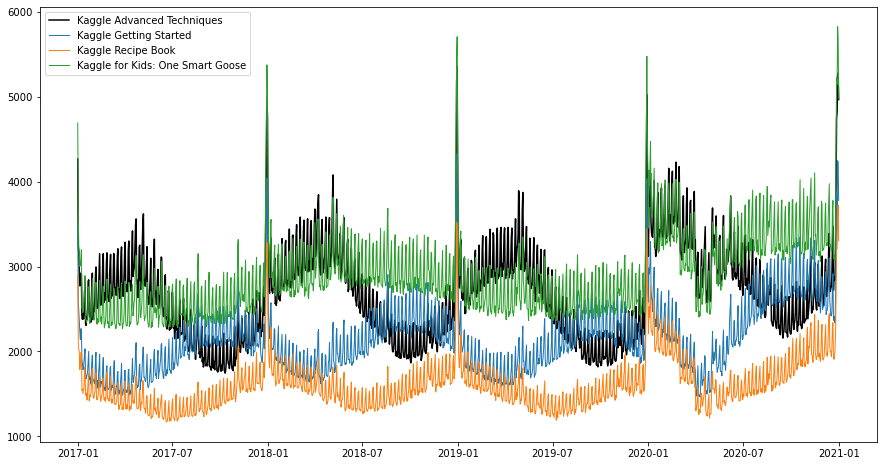

In [886]:
# Cumulative dataset based on product
temp = train.groupby(['date','product'])['num_sold'].sum()
temp = temp.unstack(level='product')
temp = temp.reset_index()

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)

plt.plot(temp['date'],temp['Kaggle Advanced Techniques'],label = 'Kaggle Advanced Techniques',color='black')
plt.plot(temp['date'],temp['Kaggle Getting Started'],label = 'Kaggle Getting Started',linewidth = 1)
plt.plot(temp['date'],temp['Kaggle Recipe Book'],label = 'Kaggle Recipe Book',linewidth=1 )
plt.plot(temp['date'],temp['Kaggle for Kids: One Smart Goose'],label = 'Kaggle for Kids: One Smart Goose',linewidth = 1)
plt.legend()
plt.show()

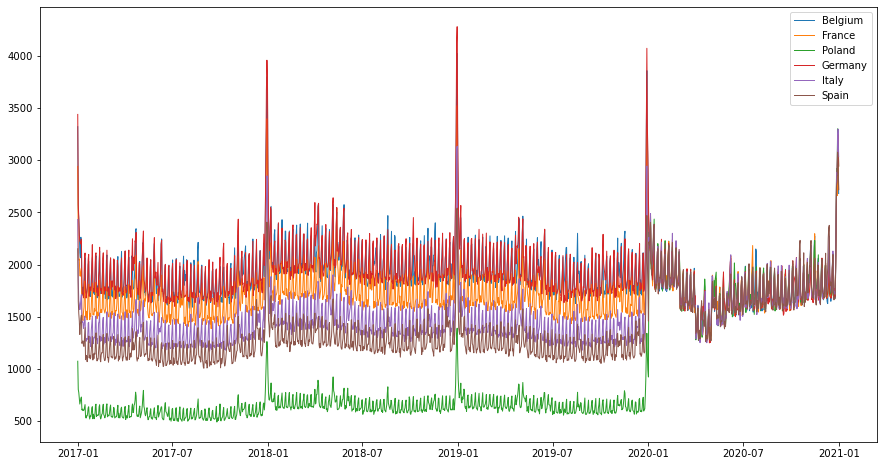

In [887]:
# Cumulative dataset based on country
temp = train.groupby(['date','country'])['num_sold'].sum()
temp = temp.unstack(level='country')
temp = temp.reset_index()

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)

plt.plot(temp['date'],temp['Belgium'],label = 'Belgium',linewidth=1)
plt.plot(temp['date'],temp['France'],label = 'France',linewidth = 1)
plt.plot(temp['date'],temp['Poland'],label = 'Poland',linewidth=1 )
plt.plot(temp['date'],temp['Germany'],label = 'Germany',linewidth = 1)
plt.plot(temp['date'],temp['Italy'],label = 'Italy',linewidth = 1)
plt.plot(temp['date'],temp['Spain'],label = 'Spain',linewidth = 1)

plt.legend()
plt.show()

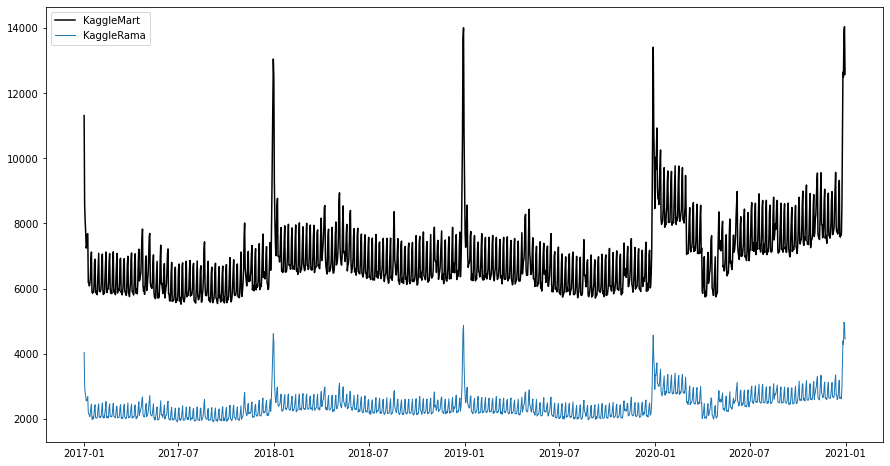

In [888]:
# Cumulative dataset based on store
temp = train.groupby(['date','store'])['num_sold'].sum()
temp = temp.unstack(level='store')
temp = temp.reset_index()

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)

plt.plot(temp['date'],temp['KaggleMart'],label = 'KaggleMart',color='black')
plt.plot(temp['date'],temp['KaggleRama'],label = 'KaggleRama',linewidth = 1)
plt.legend()
plt.show()

In [889]:
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['day'] = temp['date'].dt.day
temp['dayofweek'] = temp['date'].dt.dayofweek

In [890]:
a = temp.loc[temp['year']==2020]
a

store,date,KaggleMart,KaggleRama,year,month,day,dayofweek
1095,2020-01-01,8459,2907,2020,1,1,2
1096,2020-01-02,10030,3355,2020,1,2,3
1097,2020-01-03,9652,3329,2020,1,3,4
1098,2020-01-04,10129,3563,2020,1,4,5
1099,2020-01-05,10933,3715,2020,1,5,6
...,...,...,...,...,...,...,...
1456,2020-12-27,12650,4392,2020,12,27,6
1457,2020-12-28,12507,4282,2020,12,28,0
1458,2020-12-29,13911,4965,2020,12,29,1
1459,2020-12-30,14045,4893,2020,12,30,2


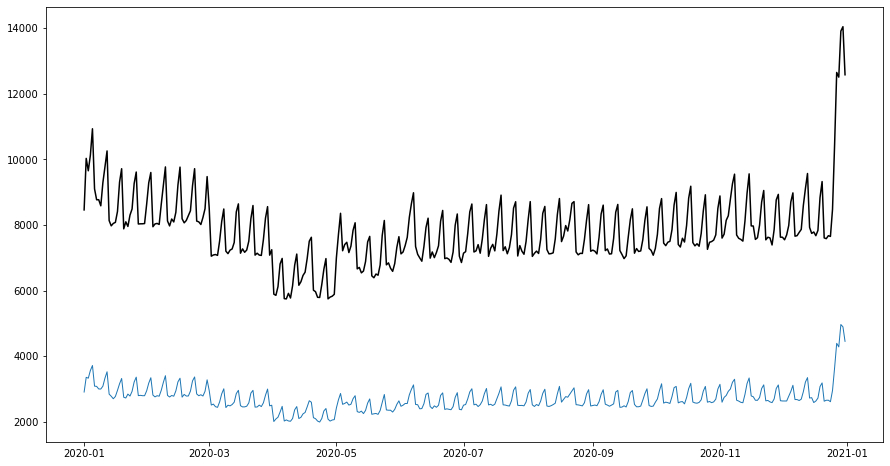

In [891]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)

plt.plot(a['date'],a['KaggleMart'],label = 'KaggleMart',color='black')
plt.plot(a['date'],a['KaggleRama'],label = 'KaggleRama',linewidth = 1)

In [892]:
# we remove data points between 03/2020 to 06/2020 due to discrepancies in the values of the dataset (probably due to covid) 

In [893]:
train = train.loc[~((train['date']>='2020-03-01')&(train['date']<'2020-06-01'))]
train1 = train1.loc[~((train1['date']>='2020-03-01')&(train1['date']<'2020-06-01'))]

In [894]:
train = train.reset_index()
train1 = train1.reset_index()

train

,index,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...,...
65707,70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
65708,70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
65709,70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158
65710,70126,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135


In [895]:
train = train[['date','country','store','product','num_sold']]
train1 = train1[['date','country','store','product','num_sold']]

In [896]:
train

,date,country,store,product,num_sold
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...
65707,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
65708,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
65709,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158
65710,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135


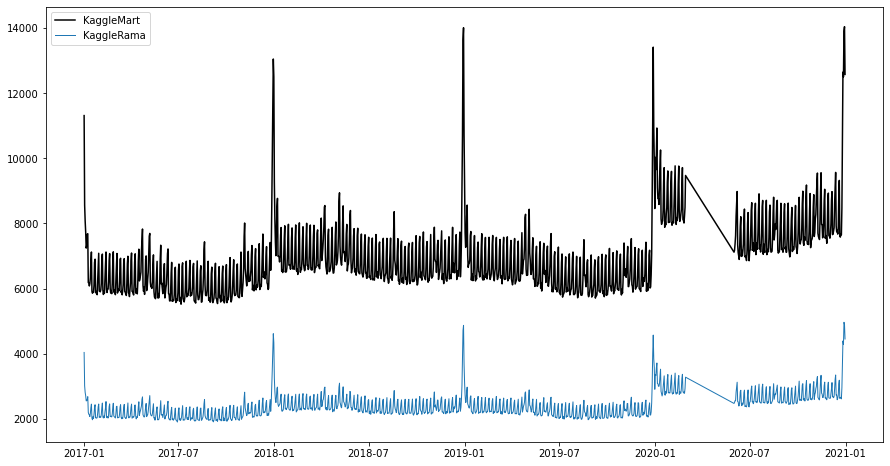

In [897]:
# Cumulative dataset based on store
temp = train.groupby(['date','store'])['num_sold'].sum()
temp = temp.unstack(level='store')
temp = temp.reset_index()

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)

plt.plot(temp['date'],temp['KaggleMart'],label = 'KaggleMart',color='black')
plt.plot(temp['date'],temp['KaggleRama'],label = 'KaggleRama',linewidth = 1)
plt.legend()
plt.show()

In [898]:
b = train.groupby(['date'])['num_sold'].sum()
b 

date
2017-01-01    15352
2017-01-02    11578
2017-01-03    10884
2017-01-04    10445
2017-01-05     9795
              ...  
2020-12-27    17042
2020-12-28    16789
2020-12-29    18876
2020-12-30    18938
2020-12-31    17031
Name: num_sold, Length: 1369, dtype: int64

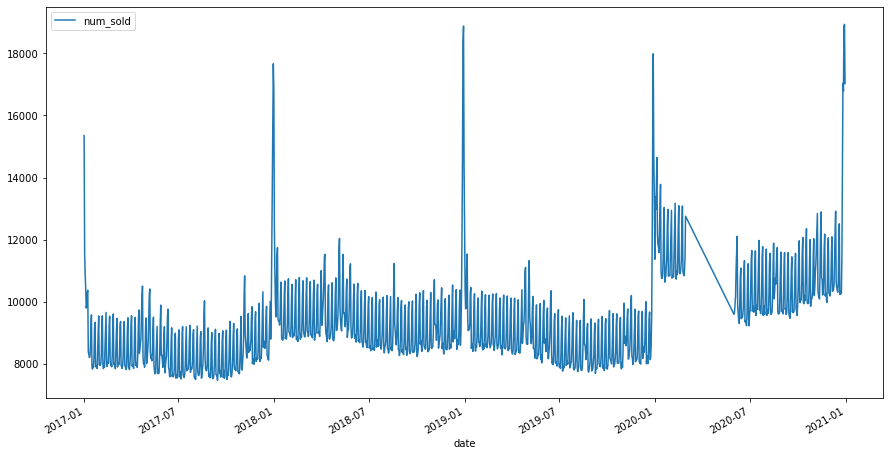

In [899]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(8)

b.plot()
plt.legend()
plt.show()

### To determine days having high, low and average purchases

In [900]:
b.mean()

9318.772096420746

In [901]:
c = pd.DataFrame(b)
c

,num_sold
date,
2017-01-01,15352
2017-01-02,11578
2017-01-03,10884
2017-01-04,10445
2017-01-05,9795
...,...
2020-12-27,17042
2020-12-28,16789
2020-12-29,18876


In [902]:
d = c.loc[c['num_sold']>10000] # high purchasing dates
d

,num_sold
date,
2017-01-01,15352
2017-01-02,11578
2017-01-03,10884
2017-01-04,10445
2017-01-07,10271
...,...
2020-12-27,17042
2020-12-28,16789
2020-12-29,18876


In [903]:
# one hot encoding, check hols and label
# use IQR to find days with least,most and average sales then encode them

In [904]:
d = d.reset_index()

In [905]:
d['year'] = d['date'].dt.year
d['month'] = d['date'].dt.month
d['day'] = d['date'].dt.day

In [906]:
d['month_day'] = d['month'].astype(str) + '-' + d['day'].astype(str)

In [907]:
e = d['month_day'].value_counts()
e = pd.DataFrame(e)
e.loc[e['month_day']>=3]

,month_day
1-1,4
12-28,4
1-2,4
12-31,4
12-30,4
12-29,4
12-27,4
2-24,3
2-17,3
2-10,3


    NOTE: 
    The following dates show high purchasing hence those days can be given as special days
    27/12,29/12,30/12,31/12 year end hols including xmas 
    1/1,2/1,3/1,5/1,6/1 year beginning week
    13/1
    20/1
    27/1
    18/8
    4/11

In [908]:
d = c.loc[c['num_sold']<8000] # low purchasing dates
d

,num_sold
date,
2017-01-16,7937
2017-01-17,7828
2017-01-18,7961
2017-01-19,7898
2017-01-23,7901
...,...
2019-10-28,7947
2019-10-29,7834
2019-10-31,7886


In [909]:
d = d.reset_index()

In [910]:
d['year'] = d['date'].dt.year
d['month'] = d['date'].dt.month
d['day'] = d['date'].dt.day

In [911]:
d['month_day'] = d['month'].astype(str) + '-' + d['day'].astype(str)

In [912]:
e = d['month_day'].value_counts()
e = pd.DataFrame(e)
e.loc[e['month_day']>=3]

,month_day


    NOTE: 
    There are no particular dates that show low purchasing numbers

In [913]:
d = c.loc[(c['num_sold']>=8000)&(c['num_sold']<10000)] # average purchasing dates
d

,num_sold
date,
2017-01-05,9795
2017-01-06,9883
2017-01-09,8378
2017-01-10,8314
2017-01-11,8199
...,...
2020-10-20,9938
2020-10-21,9993
2020-10-22,9942


In [914]:
d = d.reset_index()

In [915]:
d['year'] = d['date'].dt.year
d['month'] = d['date'].dt.month
d['day'] = d['date'].dt.day

In [916]:
d['month_day'] = d['month'].astype(str) + '-' + d['day'].astype(str)

In [917]:
e = d['month_day'].value_counts()
e = pd.DataFrame(e)
f = e.loc[e['month_day']>=3]
f = pd.DataFrame(f)
f = f.reset_index()
f['index'].unique()

array(['11-26', '6-25', '6-11', '6-8', '7-16', '7-21', '7-28', '9-22',
       '9-29', '10-6', '10-13', '10-20', '10-22', '6-18', '7-27', '8-3',
       '9-15', '10-1', '8-11', '10-8', '8-10', '10-15', '8-4', '10-21',
       '10-27', '8-24', '10-12', '11-1', '11-2', '11-6', '11-7', '11-8',
       '11-9', '11-10', '9-24', '9-17', '11-13', '8-25', '7-1', '9-7',
       '7-2', '7-9', '9-1', '8-31', '9-14', '7-23', '7-30', '9-16', '8-6',
       '8-13', '8-17', '8-21', '8-27', '9-3', '9-9', '9-10', '11-12',
       '11-14', '7-20', '6-22', '12-19', '12-20', '12-21', '12-22',
       '12-25', '6-1', '6-12', '6-19', '6-23', '12-17', '6-26', '6-29',
       '6-30', '7-6', '7-7', '9-28', '7-13', '7-14', '12-18', '12-15',
       '11-15', '11-29', '11-16', '11-19', '11-21', '11-22', '11-24',
       '9-21', '11-27', '11-28', '11-30', '12-14', '12-1', '12-3', '12-6',
       '12-7', '12-8', '12-11', '12-12', '12-13', '12-4', '9-8', '6-24',
       '1-29', '2-6', '2-5', '10-26', '4-16', '4-17', '4-18', '4-1

    NOTE: 
    These are the dates showing average spending 

In [918]:
train1['year'] = train1['date'].dt.year
train1['month'] = train1['date'].dt.month
train1['day'] = train1['date'].dt.day
train1['day of week'] = train1['date'].dt.dayofweek
train1['quarter'] = train1['date'].dt.quarter

In [919]:
def weekend(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0
temp = train1['date'].apply(weekend)
train1['weekend'] = temp

In [920]:
train1

,date,country,store,product,num_sold,year,month,day,day of week,quarter,weekend
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663,2017,1,1,6,1,1
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615,2017,1,1,6,1,1
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480,2017,1,1,6,1,1
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710,2017,1,1,6,1,1
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240,2017,1,1,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...
65707,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614,2020,12,31,3,4,0
65708,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215,2020,12,31,3,4,0
65709,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158,2020,12,31,3,4,0
65710,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135,2020,12,31,3,4,0


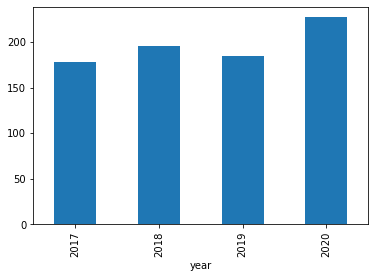

In [921]:
train1.groupby('year')['num_sold'].mean().plot.bar()
plt.show()

    NOTE:
    Global growth for the year 2019 recorded its weakest pace since the global financial crisis a decade ago, reflecting common influences across countries and country-specific factors.Rising trade barriers and associated uncertainty weighed on business sentiment and activity globally. In some cases (advanced economies and China), these developments magnified cyclical and structural slowdowns already under way.(https://www.imf.org/en/Blogs/Articles/2019/12/18/blog121819-2019-in-review-five-charts)
    
    This is probably the reason why spending has decreased in 2019.

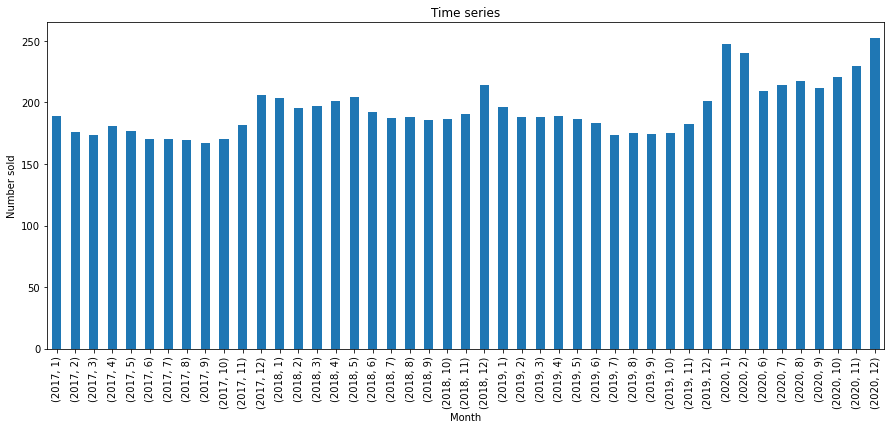

In [922]:
plt.figure(figsize=(15,6))
a = train1.groupby(['year','month'])['num_sold'].mean().plot.bar()
a.plot(title = 'Monthwise demand')
plt.title('Time series')
plt.xlabel('Month')
plt.ylabel('Number sold')
plt.show()

    NOTE:
    Months of January, April and December show highest spending.
    Months of June, July, August, September and October show lowest spending.

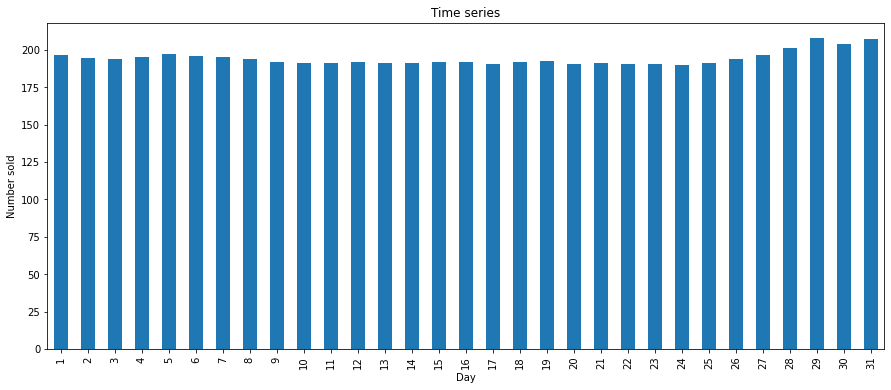

In [923]:
plt.figure(figsize=(15,6))
a = train1.groupby('day')['num_sold'].mean().plot.bar()
a.plot(title = 'Daywise demand')
plt.title('Time series')
plt.xlabel('Day')
plt.ylabel('Number sold')
plt.show()

In [924]:
train1.groupby('day')['num_sold'].mean() # mean 194.37

day
1     196.823148
2     194.700000
3     193.813889
4     195.489815
5     197.326389
6     196.132870
7     195.424074
8     194.085648
9     192.200000
10    191.524074
11    191.356944
12    191.869444
13    190.910648
14    191.206481
15    191.828241
16    191.555556
17    190.864352
18    191.937037
19    192.334259
20    190.679167
21    191.378704
22    190.729167
23    190.295833
24    189.666667
25    191.086111
26    193.566667
27    196.587963
28    201.453704
29    207.641369
30    204.137703
31    206.975160
Name: num_sold, dtype: float64

    NOTE:
    Days 1,5,6,27,28,29,30,31 show highest spending
    Days 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25 show lowest spending

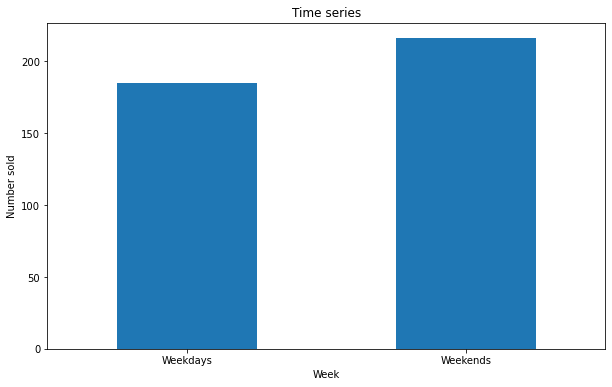

In [925]:
plt.figure(figsize=(10,6))
a = train1.groupby('weekend')['num_sold'].mean().plot.bar()
a.plot(title = 'Weekwise demand')
plt.title('Time series')
plt.xlabel('Week')
plt.ylabel('Number sold')
plt.xticks(ticks=[0,1],labels=['Weekdays','Weekends'],rotation = 0)
plt.show()

    NOTE:
     Weekends show higher spending

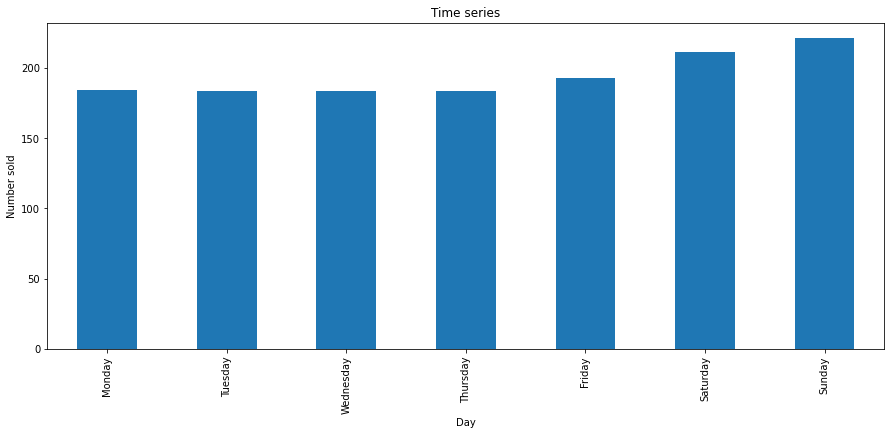

In [926]:
plt.figure(figsize=(15,6))
a = train1.groupby('day of week')['num_sold'].mean().plot.bar()
a.plot(title = 'Daywise demand')
plt.title('Time series')
plt.xlabel('Day')
plt.ylabel('Number sold')
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.show()

In [927]:
train1.groupby('day of week')['num_sold'].mean()

day of week
0    183.896046
1    183.590136
2    183.232249
3    183.529337
4    192.490705
5    211.451496
6    221.014637
Name: num_sold, dtype: float64

    NOTE:
    Friday, Saturday, Sunday show higher spending
    Wednesday, Thursday show lower spending

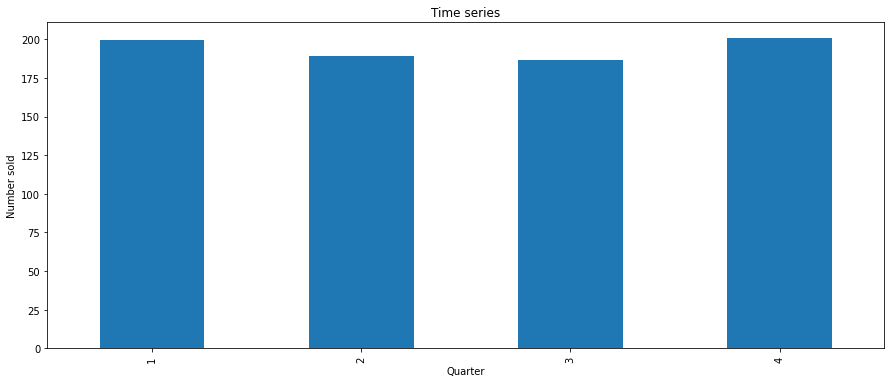

In [928]:
plt.figure(figsize=(15,6))
a = train1.groupby('quarter')['num_sold'].mean().plot.bar()
a.plot(title = 'Quarterwise demand')
plt.title('Time series')
plt.xlabel('Quarter')
plt.ylabel('Number sold')
#plt.xticks(ticks=[0,1,2,3,4,5,6],labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.show()

    NOTE:
    1st and 4th quarter shows highest while 3rd quarter shows lowest

## Building hybrid model - Random Forest and Adaboost

In [929]:
train

,date,country,store,product,num_sold
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...
65707,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
65708,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
65709,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158
65710,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135


## Model Building

In [930]:
def date_feat_eng_X1(df):
    df['year']=df['date'].dt.year                   # 2015 to 2019
    return df

In [931]:
def dropdate(df):
    df=df.drop('date',axis=1)
    return df

def onehot(df,columns):
    df=pd.get_dummies(df, columns,drop_first=True)
    return df

In [839]:
def get_holidays(df):
    # Converting date to divisions
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day of week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    
    def weekend(row):
        if row.dayofweek == 5 or row.dayofweek == 6:
            return 1
        else:
            return 0
    temp = df['date'].apply(weekend)
    df['weekend'] = temp
    
    # Encoding the divisions
    # Encoding special days and the rest
    for i in range(len(df['date'])):
        #df['time'][i] = (df['date'][i] - df['date'][0]).days
        a_day = df['date'][i].day 
        a_month = df['date'][i].month
        a_month_day = str(a_month) + '-' + str(a_day)
        if a_month_day in ['12-27','12-29','12-30','12-31','1-1','1-2','1-3','1-5','1-6','1-13','1-20','8-18','11-4']:
            df['date'][i] = 3
        elif a_month_day in ['11-26', '6-25', '6-11', '6-8', '7-16', '7-21', '7-28', '9-22',
                             '9-29', '10-6', '10-13', '10-20', '10-22', '6-18', '7-27', '8-3',
                             '9-15', '10-1', '8-11', '10-8', '8-10', '10-15', '8-4', '10-21',
                             '10-27', '8-24', '10-12', '11-1', '11-2', '11-6', '11-7', '11-8',
                             '11-9', '11-10', '9-24', '9-17', '11-13', '8-25', '7-1', '9-7',
                             '7-2', '7-9', '9-1', '8-31', '9-14', '7-23', '7-30', '9-16', '8-6',
                             '8-13', '8-17', '8-21', '8-27', '9-3', '9-9', '9-10', '11-12',
                             '11-14', '7-20', '6-22', '12-19', '12-20', '12-21', '12-22',
                             '12-25', '6-1', '6-12', '6-19', '6-23', '12-17', '6-26', '6-29',
                             '6-30', '7-6', '7-7', '9-28', '7-13', '7-14', '12-18', '12-15',
                             '11-15', '11-29', '11-16', '11-19', '11-21', '11-22', '11-24',
                             '9-21', '11-27', '11-28', '11-30', '12-14', '12-1', '12-3', '12-6',
                             '12-7', '12-8', '12-11', '12-12', '12-13', '12-4', '9-8', '6-24',
                             '1-29', '2-6', '2-5', '10-26', '4-16', '4-17', '4-18', '4-19',
                             '4-20', '4-24', '4-25', '4-26', '2-2', '4-30', '5-1', '5-2', '4-9',
                             '2-8', '4-2', '3-8', '6-17', '2-19', '2-20', '2-26', '2-28', '3-5',
                             '3-12', '2-12', '2-16', '3-19', '2-15', '2-13', '3-26', '3-30',
                             '5-3', '4-12', '6-4', '5-28', '5-29', '5-30', '6-10', '1-9',
                             '5-31', '5-21', '1-11', '1-15', '6-9', '5-14', '1-10', '6-3',
                             '1-22', '5-11', '6-7', '5-10', '5-9', '5-8']:
            df['date'][i] = 2
        else:
            df['date'][i] = 1
            
    # Encoding the year
        if df['year'][i]== 2020:
            df['year'][i] = 4
        elif df['year'][i] == 2019:
            df['year'][i] = 3
        elif df['year'][i] == 2018:
            df['year'][i] = 2 
        elif df['year'][i] == 2017:
            df['year'][i] = 1
        elif df['year'][i] > 2020:
            df['year'][i] = 5
        else:
            df['year'][i] = 0
            
    # Encoding the month
    for i in range(len(df['year'])):
        if df['month'][i] in [1,4,12]:
            df['month'][i] = 3
        elif df['month'][i] in [6,7,8,9,10]:
            df['month'][i] = 1
        else:
            df['month'][i] = 2
    
    # Encoding the day
        if df['day'][i] in [1,5,6,27,28,29,30,31]:
            df['day'][i] = 3
        elif df['day'][i] in [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]:
            df['day'][i] = 1
        else:
            df['day'][i] = 2
            
    # Encoding the day of week
        if df['day of week'][i] in [4,5,6]:
            df['day of week'][i] = 3
        elif df['day of week'][i] in [2,3]:
            df['day of week'][i] = 1
        else:
            df['day of week'][i] = 2
    
    
    # Encoding the quarter
        if df['quarter'][i] in [1,4]:
            df['quarter'][i] = 3
        elif df['quarter'][i] == 3:
            df['quarter'][i] = 1
        else:
            df['quarter'][i] = 2    
            
    return df

In [932]:
test

,date,country,store,product
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques
...,...,...,...,...
17515,2021-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose
17516,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques
17517,2021-12-31,Spain,KaggleRama,Kaggle Getting Started
17518,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book


In [840]:
train.drop(train[(train['date'].dt.month==2) & (train['date'].dt.day==29)].index, axis=0, inplace=True)

In [841]:
train = train.reset_index()
train = train[['date','country','store','product','num_sold']]

In [842]:
X = train.drop('num_sold',axis=1)
#X.dropna(inplace=True)  # drop missing values in the feature set

y = train['num_sold']  # create the target

In [843]:
X

,date,country,store,product
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques
...,...,...,...,...
65659,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose
65660,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques
65661,2020-12-31,Spain,KaggleRama,Kaggle Getting Started
65662,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book


In [844]:
y

0        663
1        615
2        480
3        710
4        240
        ... 
65659    614
65660    215
65661    158
65662    135
65663    202
Name: num_sold, Length: 65664, dtype: int64

In [845]:
# Feature set for trend model
def FeatEng_X1(df):
    df=date_feat_eng_X1(df)
    df=dropdate(df)
    df=onehot(df,['store', 'product', 'country'])
    return df

# Feature set for interactions model
def FeatEng_X2(df):
    df=get_holidays(df)
    df=dropdate(df)
    df=onehot(df,['store', 'product', 'country'])
    return df

# Apply feature engineering
X_train_1=FeatEng_X1(X)
X_train_2=FeatEng_X2(X)
X_test_1=FeatEng_X1(test)
X_test_2=FeatEng_X2(test)

In [867]:
# A class is a collection of properties and methods (like models from Sklearn)
class HybridModel:
    def __init__(self, model_1, model_2, grid=None):
        self.model_1 = model_1
        self.model_2 = model_2
        self.grid=grid
        
    def fitting(self, X_train_1, X_train_2, y):
        # Train model 1
        self.model_1.fit(X_train_1, y)
        
        # Predictions from model 1 (trend)
        y_trend = self.model_1.predict(X_train_1)

        if self.grid:
            # Grid search
            tscv = TimeSeriesSplit(n_splits=3)
            grid_model = GridSearchCV(estimator=self.model_2, cv=tscv, param_grid=self.grid)
        
            # Train model 2 on detrended series
            grid_model.fit(X_train_2, y-y_trend)
            
            # Model 2 preditions (for residual analysis)
            y_resid = grid_model.predict(X_train_2)
            
            # Save model
            self.grid_model=grid_model
        else:
            # Train model 2 on residuals
            self.model_2.fit(X_train_2, y-y_trend)
            
            # Model 2 preditions (for residual analysis)
            y_resid = self.model_2.predict(X_train_2)
        
        # Save data
        self.y_train_trend = y_trend
        self.y_train_resid = y_resid
        
    def predict(self, X_test_1, X_test_2):
        # Predict trend using model 1
        y_trend = self.model_1.predict(X_test_1)
        
        if self.grid:
            # Grid model predictions
            y_resid = self.grid_model.predict(X_test_2)
        else:
            # Model 2 predictions
            y_resid = self.model_2.predict(X_test_2)
        
        # Add predictions together
        y_pred = y_trend + y_resid
        
        # Save data
        self.y_test_trend = y_trend
        self.y_test_resid = y_resid
        
        return y_pred

In [852]:
X_train_2

,year,month,day,day of week,quarter,weekend,store_France,store_Germany,store_Italy,store_Poland,store_Spain,product_KaggleRama,country_Kaggle Getting Started,country_Kaggle Recipe Book,country_Kaggle for Kids: One Smart Goose
0,1,3,3,3,3,1,0,0,0,0,0,0,0,0,0
1,1,3,3,3,3,1,0,0,0,0,0,0,1,0,0
2,1,3,3,3,3,1,0,0,0,0,0,0,0,1,0
3,1,3,3,3,3,1,0,0,0,0,0,0,0,0,1
4,1,3,3,3,3,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65659,4,3,3,1,3,0,0,0,0,0,1,0,0,0,1
65660,4,3,3,1,3,0,0,0,0,0,1,1,0,0,0
65661,4,3,3,1,3,0,0,0,0,0,1,1,1,0,0
65662,4,3,3,1,3,0,0,0,0,0,1,1,0,1,0


In [853]:
import re
X_train_2 = X_train_2.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [868]:
X_train_2

,year,month,day,dayofweek,quarter,weekend,store_France,store_Germany,store_Italy,store_Poland,store_Spain,product_KaggleRama,country_KaggleGettingStarted,country_KaggleRecipeBook,country_KaggleforKidsOneSmartGoose
0,1,3,3,3,3,1,0,0,0,0,0,0,0,0,0
1,1,3,3,3,3,1,0,0,0,0,0,0,1,0,0
2,1,3,3,3,3,1,0,0,0,0,0,0,0,1,0
3,1,3,3,3,3,1,0,0,0,0,0,0,0,0,1
4,1,3,3,3,3,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65659,4,3,3,1,3,0,0,0,0,0,1,0,0,0,1
65660,4,3,3,1,3,0,0,0,0,0,1,1,0,0,0
65661,4,3,3,1,3,0,0,0,0,0,1,1,1,0,0
65662,4,3,3,1,3,0,0,0,0,0,1,1,0,1,0


In [869]:
X_test_2

,year,month,day,dayofweek,quarter,weekend,store_France,store_Germany,store_Italy,store_Poland,store_Spain,product_KaggleRama,country_KaggleGettingStarted,country_KaggleRecipeBook,country_KaggleforKidsOneSmartGoose
0,5,3,3,3,3,0,0,0,0,0,0,0,0,0,0
1,5,3,3,3,3,0,0,0,0,0,0,0,1,0,0
2,5,3,3,3,3,0,0,0,0,0,0,0,0,1,0
3,5,3,3,3,3,0,0,0,0,0,0,0,0,0,1
4,5,3,3,3,3,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,5,3,3,3,3,0,0,0,0,0,1,0,0,0,1
17516,5,3,3,3,3,0,0,0,0,0,1,1,0,0,0
17517,5,3,3,3,3,0,0,0,0,0,1,1,1,0,0
17518,5,3,3,3,3,0,0,0,0,0,1,1,0,1,0


In [856]:
X_test_2 = X_test_2.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [857]:
X_test_2

,year,month,day,dayofweek,quarter,weekend,store_France,store_Germany,store_Italy,store_Poland,store_Spain,product_KaggleRama,country_KaggleGettingStarted,country_KaggleRecipeBook,country_KaggleforKidsOneSmartGoose
0,5,3,3,3,3,0,0,0,0,0,0,0,0,0,0
1,5,3,3,3,3,0,0,0,0,0,0,0,1,0,0
2,5,3,3,3,3,0,0,0,0,0,0,0,0,1,0
3,5,3,3,3,3,0,0,0,0,0,0,0,0,0,1
4,5,3,3,3,3,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,5,3,3,3,3,0,0,0,0,0,1,0,0,0,1
17516,5,3,3,3,3,0,0,0,0,0,1,1,0,0,0
17517,5,3,3,3,3,0,0,0,0,0,1,1,1,0,0
17518,5,3,3,3,3,0,0,0,0,0,1,1,0,1,0


In [870]:
# Choose models 1
model_1=RandomForestRegressor()
models_2=[LGBMRegressor(random_state=0), AdaBoostRegressor(random_state=0), XGBRegressor(random_state=0)]

# Parameter grid
param_grid = {'n_estimators': [100, 150, 200, 225, 250, 275, 300],
        'learning_rate': [0.1, 0.12, 0.13, 0.14, 0.15]}

# Initialise output vectors
y_pred=np.zeros(len(test))
train_preds=np.zeros(len(y))

# Ensemble predictions
for model_2 in models_2:
    
    # Construct hybrid model
    model = HybridModel(model_1, model_2, grid=param_grid)

    # Train model
    model.fitting(X_train_1, X_train_2, np.log(y))

    # Save predictions
    y_pred += np.exp(model.predict(X_test_1,X_test_2))
    
    # Training set predictions (for residual analysis)
    train_preds += np.exp(model.y_train_trend+model.y_train_resid)

    print(f'Model_2:{model_2}')
    
    if model.grid:
        print('Best parameters:',model.grid_model.best_params_,'\n')
    
# Scale
y_pred = y_pred/len(models_2)
train_preds = train_preds/len(models_2)

Model_2:LGBMRegressor(random_state=0)
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100} 

Model_2:AdaBoostRegressor(random_state=0)
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100} 

Model_2:XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100} 



In [938]:
test.row_id

0        70128
1        70129
2        70130
3        70131
4        70132
         ...  
17515    87643
17516    87644
17517    87645
17518    87646
17519    87647
Name: row_id, Length: 17520, dtype: int64

In [940]:
y_pred

array([[0.0000e+00, 4.1000e+02],
       [1.0000e+00, 3.2800e+02],
       [2.0000e+00, 2.7500e+02],
       ...,
       [1.7517e+04, 1.1300e+02],
       [1.7518e+04, 9.4000e+01],
       [1.7519e+04, 1.5400e+02]])

In [945]:
# Choose models 2
model_1=RandomForestRegressor()
models_2=[AdaBoostRegressor(random_state=0)]

# Parameter grid
param_grid = {'n_estimators': [100, 150, 200, 225, 250, 275, 300],
        'learning_rate': [0.1, 0.12, 0.13, 0.14, 0.15]}

# Initialise output vectors
y_pred=np.zeros(len(test))
train_preds=np.zeros(len(y))

# Ensemble predictions
for model_2 in models_2:
    
    # Construct hybrid model
    model = HybridModel(model_1, model_2, grid=param_grid)

    # Train model
    model.fitting(X_train_1, X_train_2, np.log(y))

    # Save predictions
    y_pred += np.exp(model.predict(X_test_1,X_test_2))
    
    # Training set predictions (for residual analysis)
    train_preds += np.exp(model.y_train_trend+model.y_train_resid)

    print(f'Model_2:{model_2}')
    
    if model.grid:
        print('Best parameters:',model.grid_model.best_params_,'\n')
    
# Scale
y_pred = y_pred/len(models_2)
train_preds = train_preds/len(models_2)

Model_2:AdaBoostRegressor(random_state=0)
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100} 



In [950]:
# Choose models 3
model_1=RandomForestRegressor()
models_2=[LGBMRegressor(random_state=0), CatBoostRegressor(random_state=0, verbose=False), XGBRegressor(random_state=0)]


# Parameter grid
param_grid = {'n_estimators': [100, 150, 200, 225, 250, 275, 300],
        'max_depth': [4, 5, 6, 7],
        'learning_rate': [0.1, 0.12, 0.13, 0.14, 0.15]}


# Initialise output vectors
y_pred=np.zeros(len(test))
train_preds=np.zeros(len(y))

# Ensemble predictions
for model_2 in models_2:
    
    # Construct hybrid model
    model = HybridModel(model_1, model_2, grid=param_grid)

    # Train model
    model.fitting(X_train_1, X_train_2, np.log(y))

    # Save predictions
    y_pred += np.exp(model.predict(X_test_1,X_test_2))
    
    # Training set predictions (for residual analysis)
    train_preds += np.exp(model.y_train_trend+model.y_train_resid)

    print(f'Model_2:{model_2}')
    
    if model.grid:
        print('Best parameters:',model.grid_model.best_params_,'\n')
    
# Scale
y_pred = y_pred/len(models_2)
train_preds = train_preds/len(models_2)

Model_2:LGBMRegressor(random_state=0)
Best parameters: {'learning_rate': 0.14, 'max_depth': 4, 'n_estimators': 100} 

Model_2:<catboost.core.CatBoostRegressor object at 0x000002694BBDB220>
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} 

Model_2:XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)
Best parameters: {'learning_rate': 0.13, 'max_depth

In [951]:
# From https://www.kaggle.com/fergusfindley/ensembling-and-rounding-techniques-comparison
def geometric_round(arr):
    result_array = arr
    result_array = np.where(result_array < np.sqrt(np.floor(arr)*np.ceil(arr)), np.floor(arr), result_array)
    result_array = np.where(result_array >= np.sqrt(np.floor(arr)*np.ceil(arr)), np.ceil(arr), result_array)
    return result_array

y_pred=geometric_round(y_pred)

# Save predictions to file
output = pd.DataFrame({'row_id': test.row_id, 'num_sold': y_pred})

# Check format
output.head()

,row_id,num_sold
0,70128,432.0
1,70129,356.0
2,70130,294.0
3,70131,483.0
4,70132,149.0


In [943]:
output

,row_id,num_sold
0,70128,416.0
1,70129,348.0
2,70130,288.0
3,70131,468.0
4,70132,144.0
...,...,...
17515,87643,466.0
17516,87644,144.0
17517,87645,121.0
17518,87646,99.0


In [942]:
output['row_id'] = test['row_id']

In [952]:
output.to_csv('submission2.csv', index=False)

In [872]:
def plot_predictions(SS, CC, PP, series=output):
    '''
    SS=store
    CC=country
    PP=product
    '''
    
    # uncomment if your dataframes have different names
    #train_data=train_df
    #test_data=test_df
    
    # Training set target
    train_subset=train[(train.store==SS)&(train.country==CC)&(train['product']==PP)]
    
    # Predictions
    plot_index=test[(test['store']==SS)&(test['country']==CC)&(test['product']==PP)].index
    pred_subset=series[series.row_id.isin(plot_index)].reset_index(drop=True)
    
    # Plot
    plt.figure(figsize=(12,5))
    n1=len(train_subset['num_sold'])
    n2=len(pred_subset['num_sold'])
    plt.plot(np.arange(n1),train_subset['num_sold'], label='Training')
    plt.plot(np.arange(n1,n1+n2),pred_subset['num_sold'], label='Predictions')
    plt.title('\n'+f'Store:{SS}, Country:{CC}, Product:{PP}')
    plt.legend()
    plt.xlabel('Days since 2017-01-01')
    plt.ylabel('num_sold')

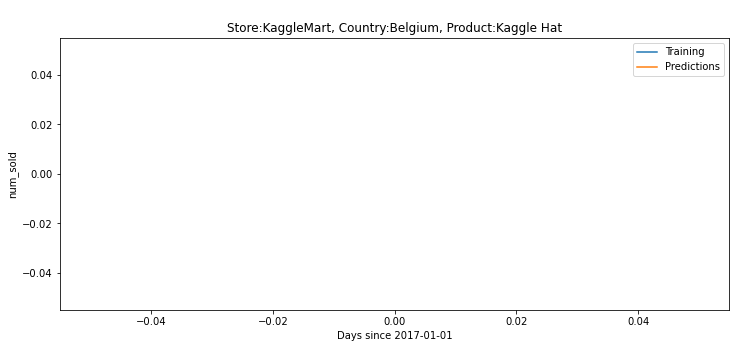

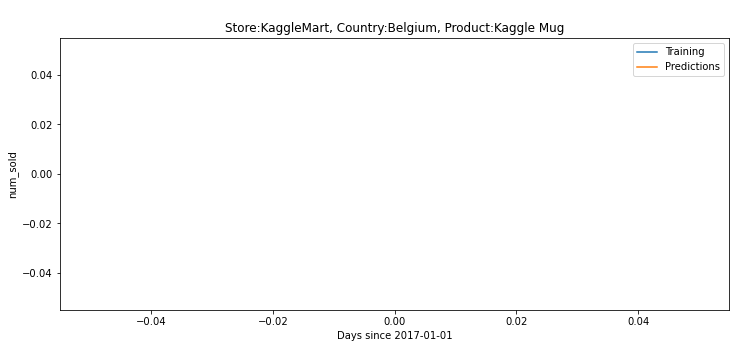

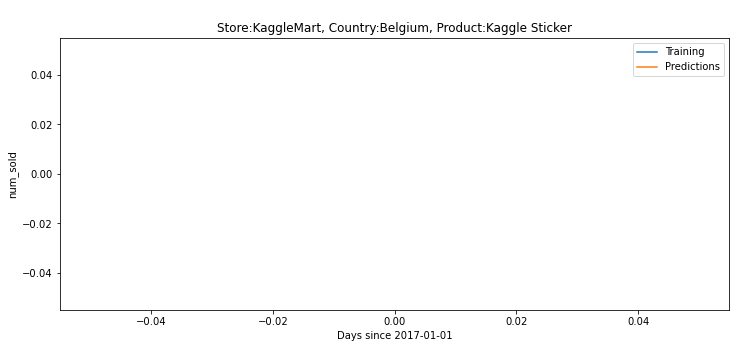

In [873]:
# Put into dataframes
#y_trend=pd.DataFrame({'row_id': test.index, 'num_sold': np.exp(model.y_test_trend)})
#y_resid=pd.DataFrame({'row_id': test.index, 'num_sold': np.exp(model.y_test_resid)})
#y_pred=pd.DataFrame({'row_id': test.index, 'num_sold': np.exp(model.y_test_trend+model.y_test_resid)})

# Choose parameters
#SS='KaggleMart'
#CC='Belgium'


# Plot trends (model 1 predictions)
#plot_predictions(SS, CC, 'Kaggle Hat', series=y_trend)
#plot_predictions(SS, CC, 'Kaggle Mug', series=y_trend)
#plot_predictions(SS, CC, 'Kaggle Sticker', series=y_trend)

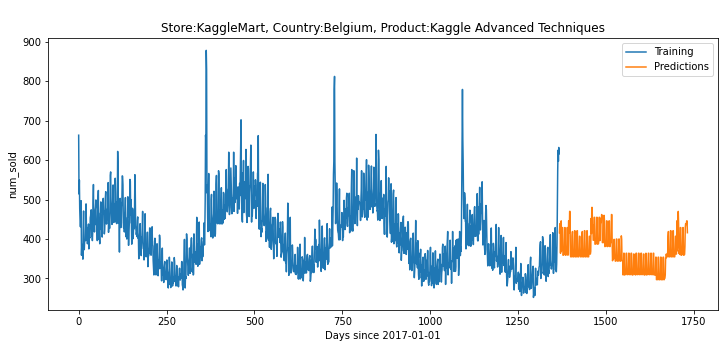

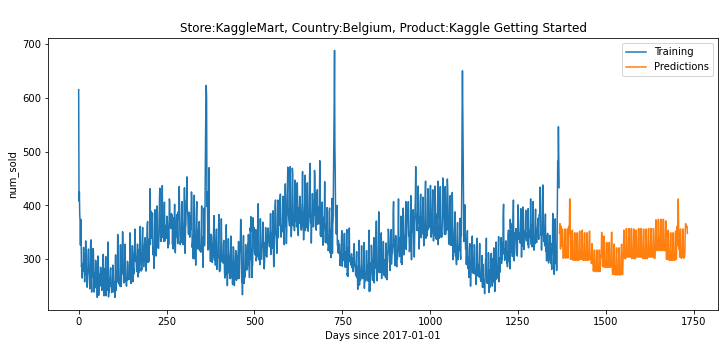

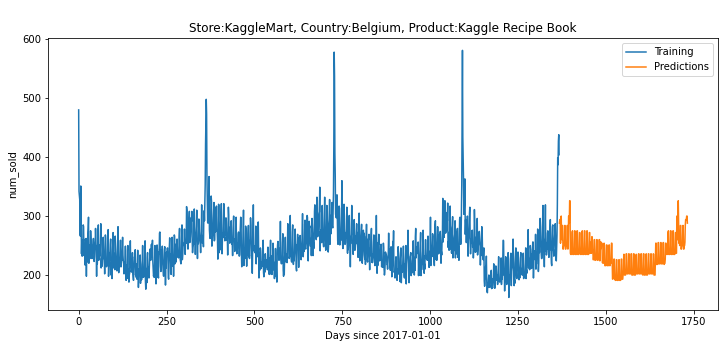

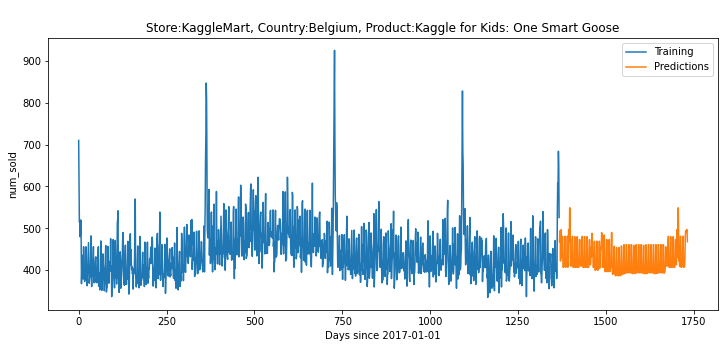

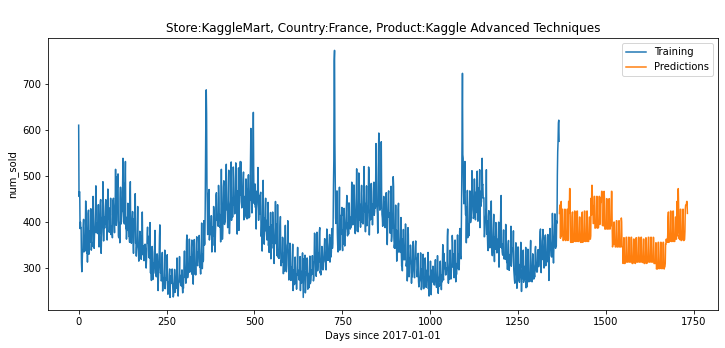

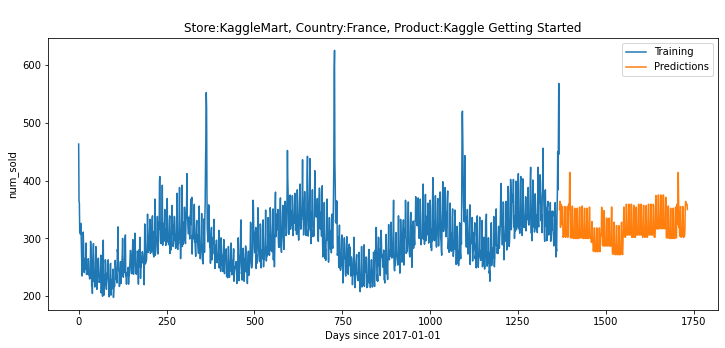

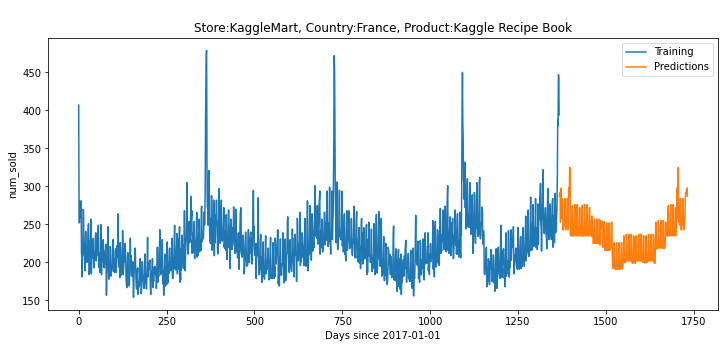

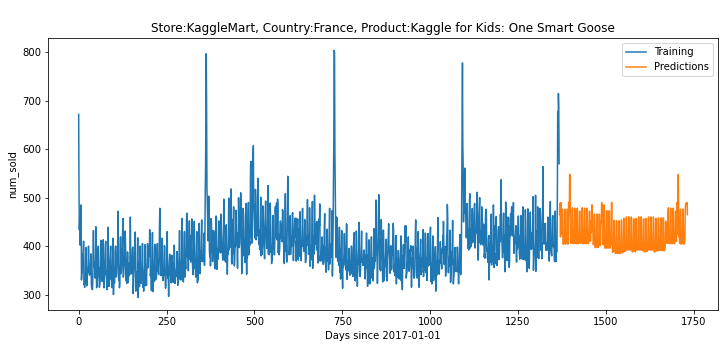

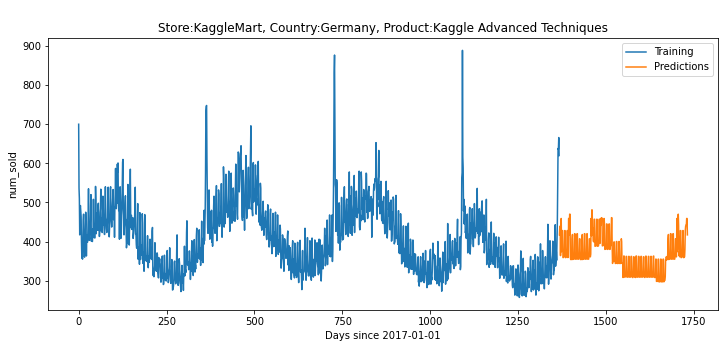

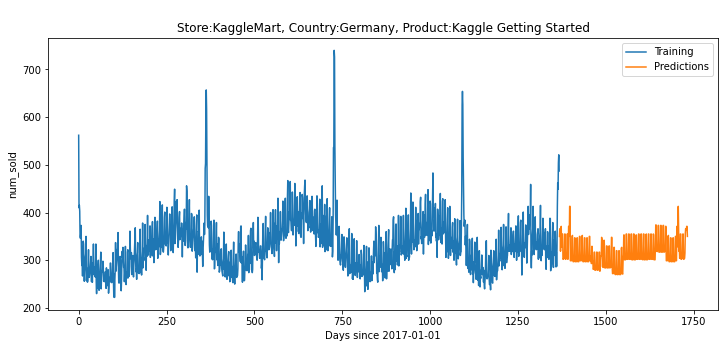

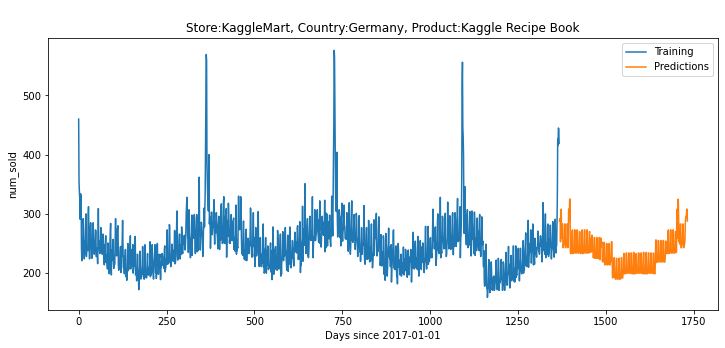

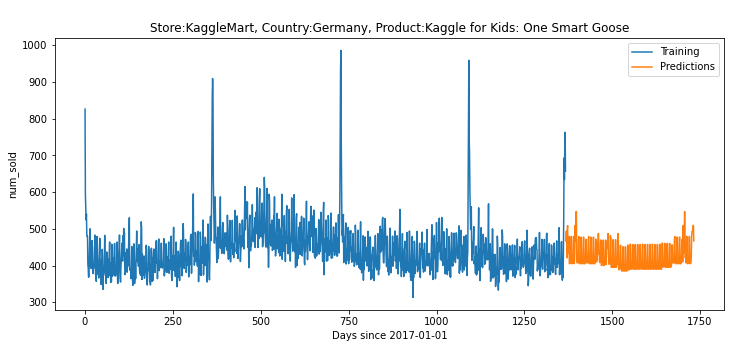

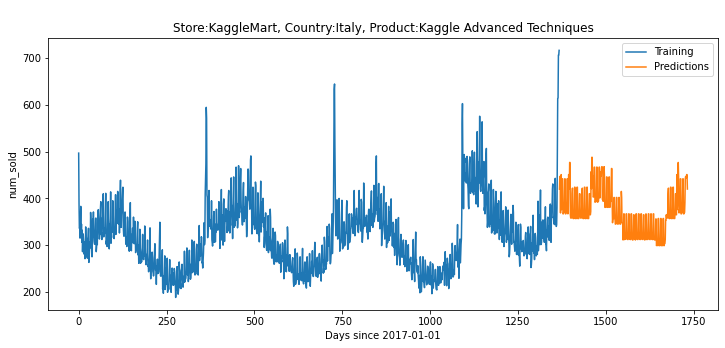

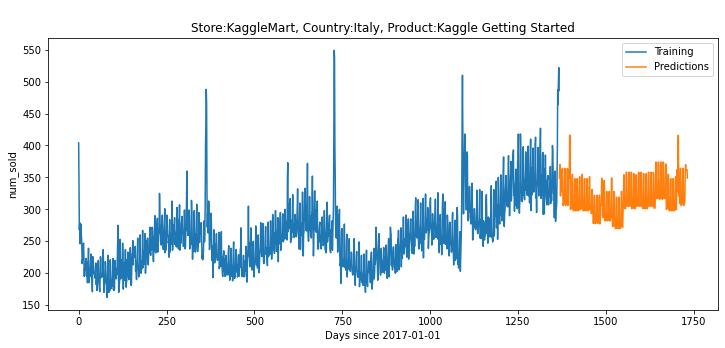

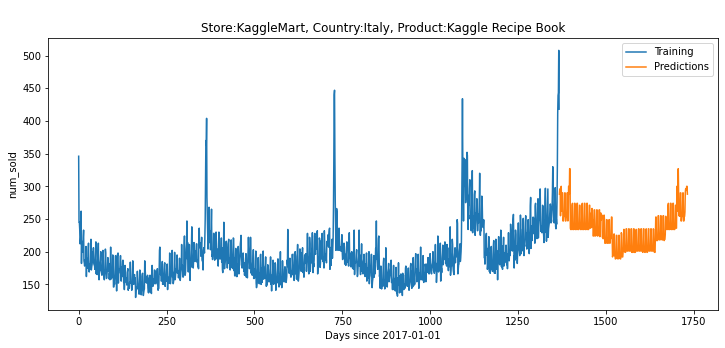

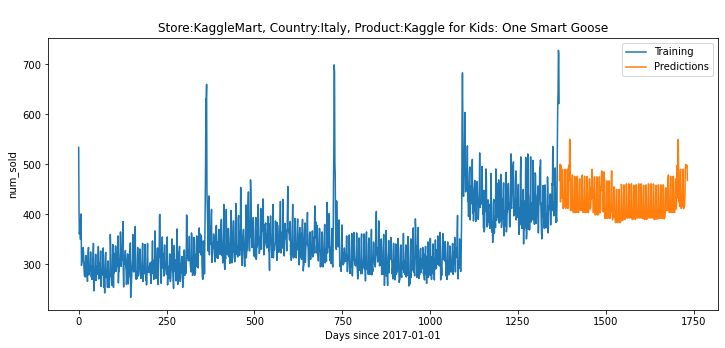

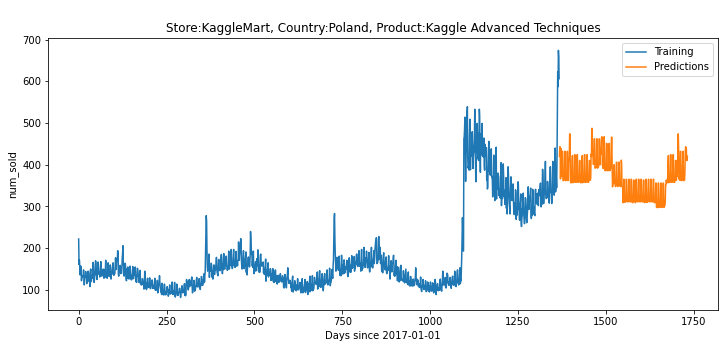

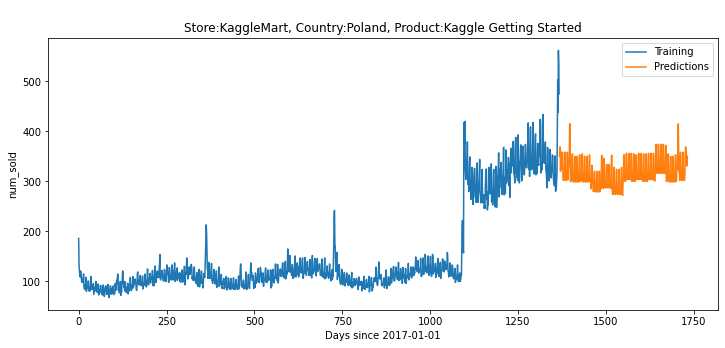

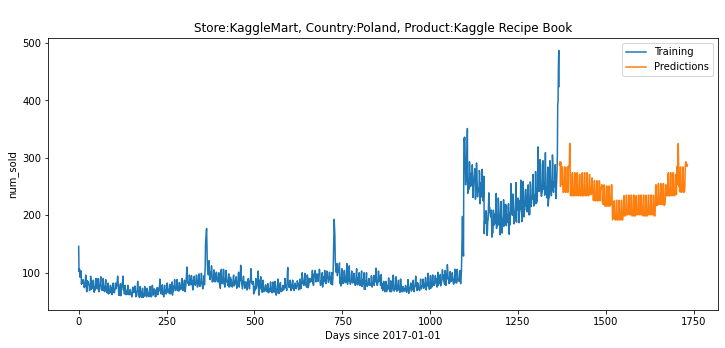

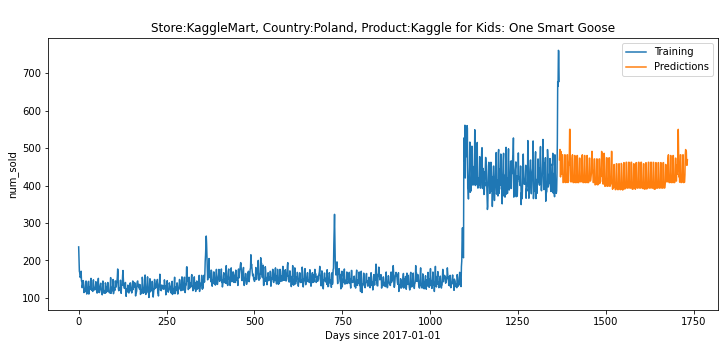

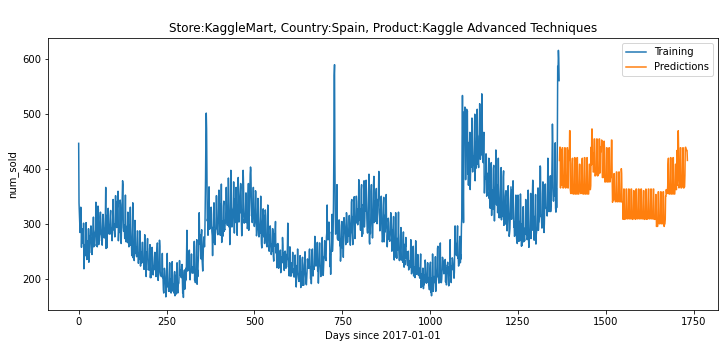

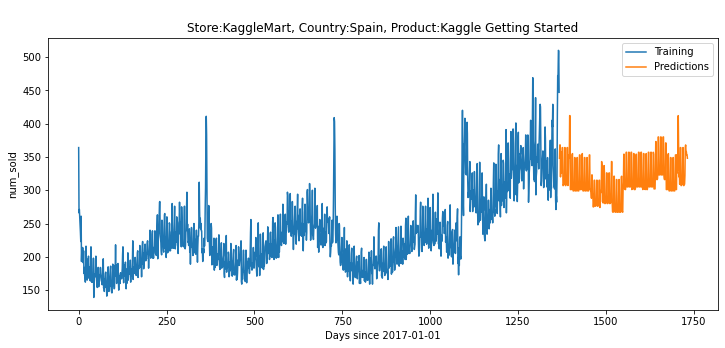

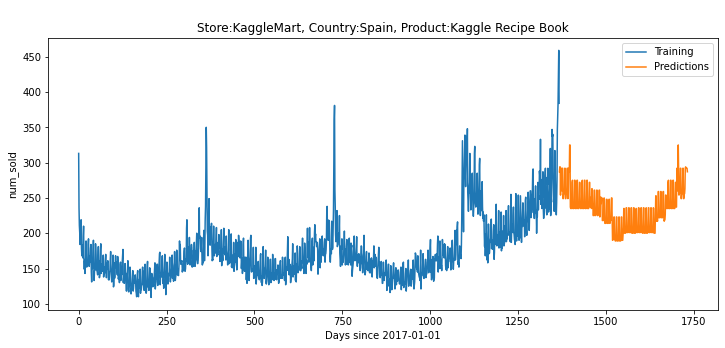

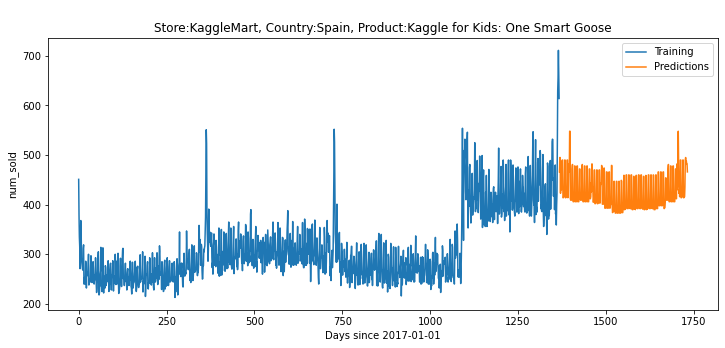

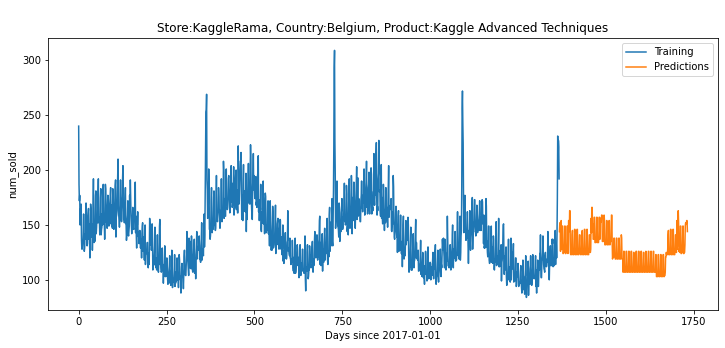

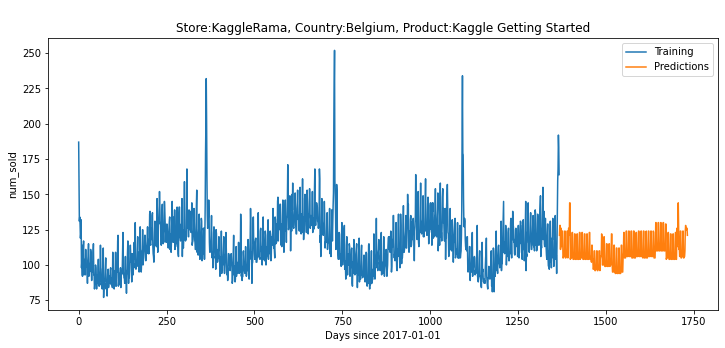

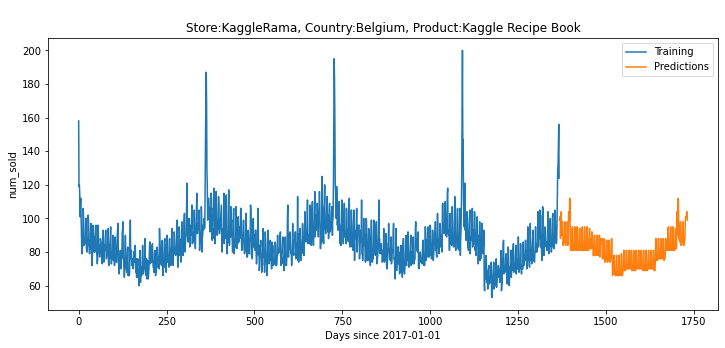

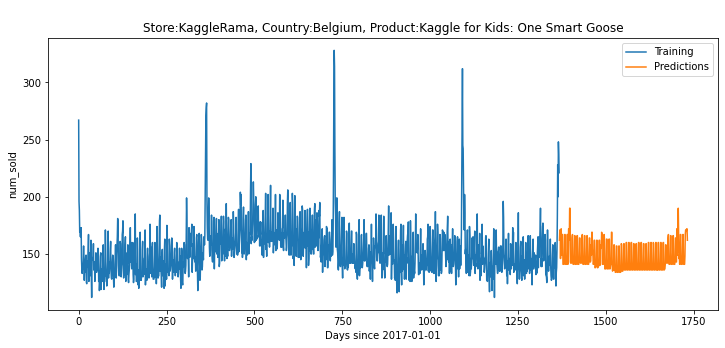

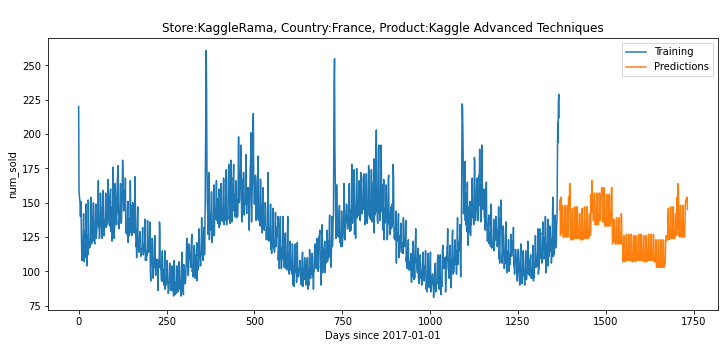

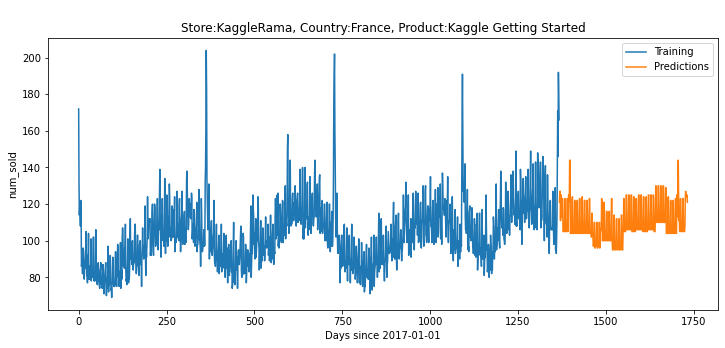

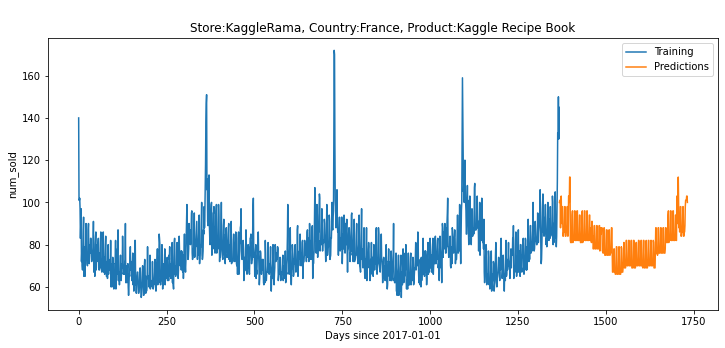

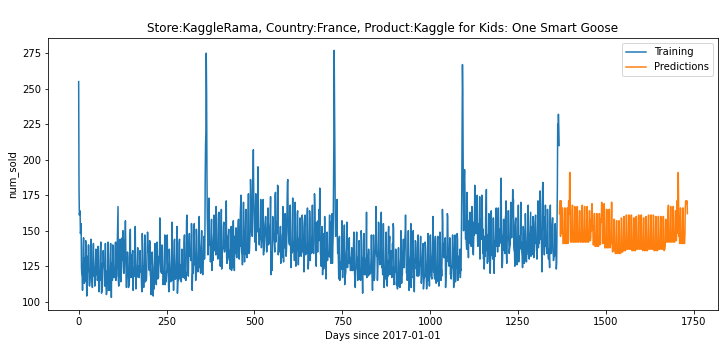

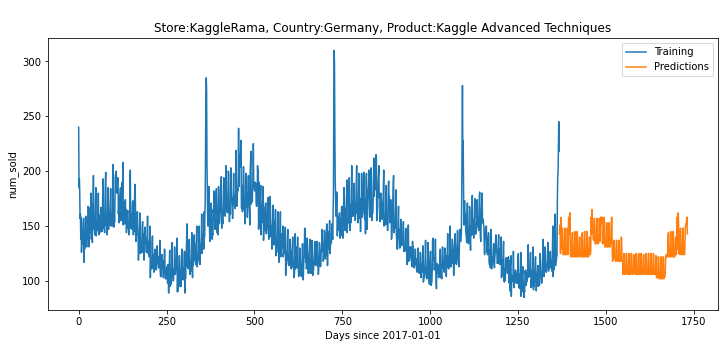

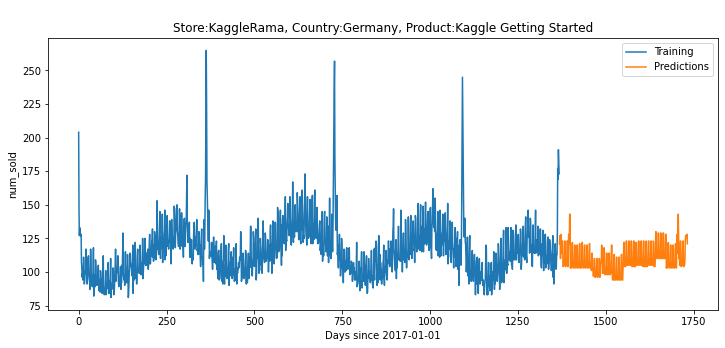

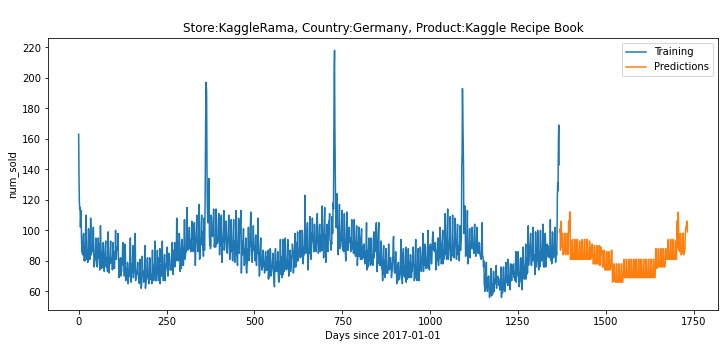

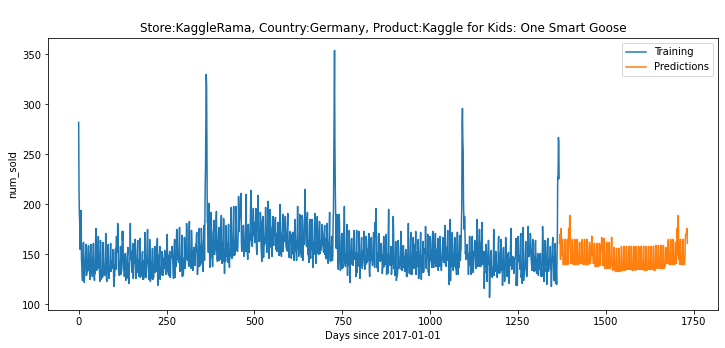

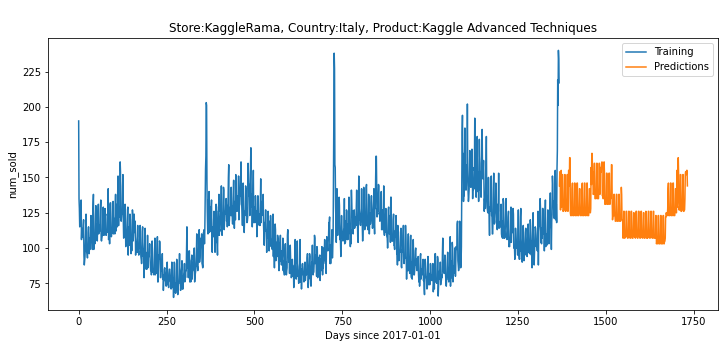

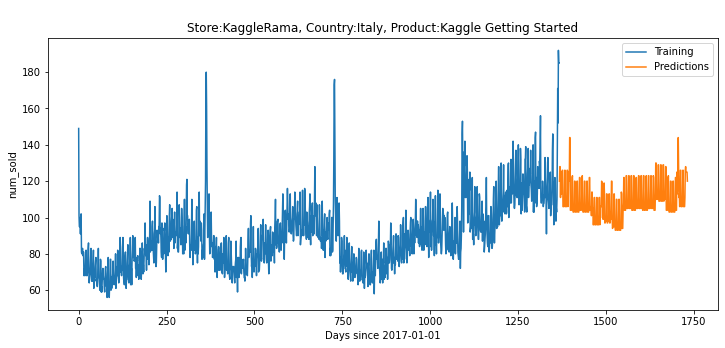

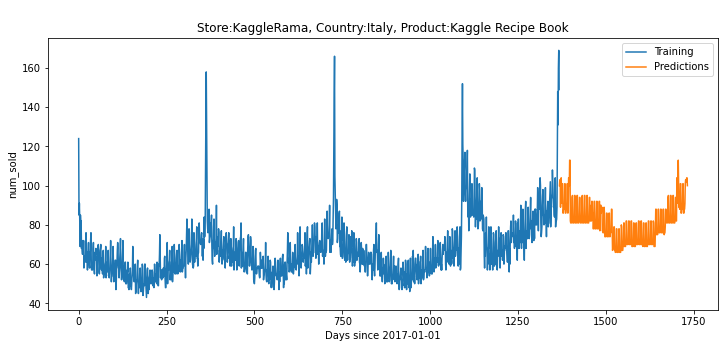

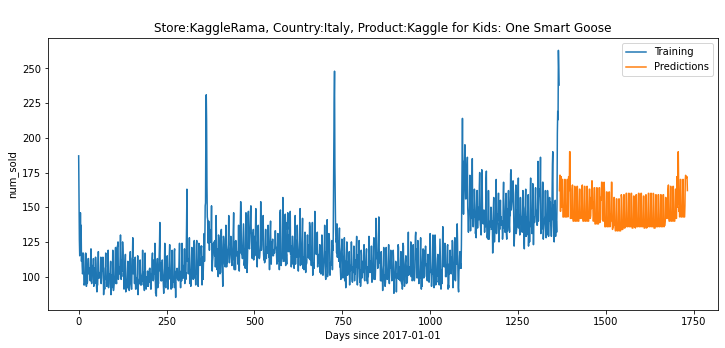

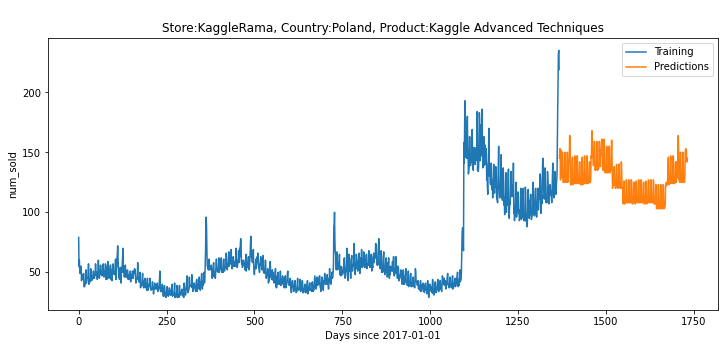

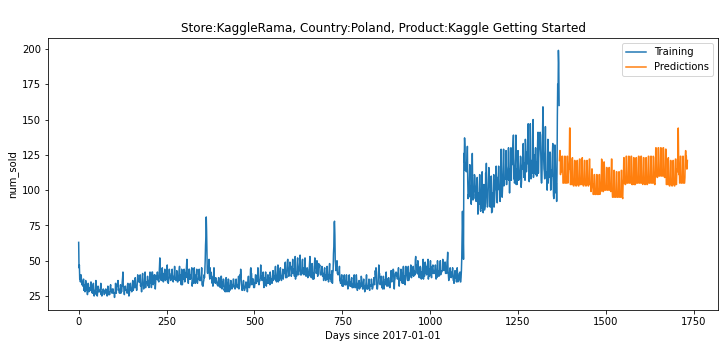

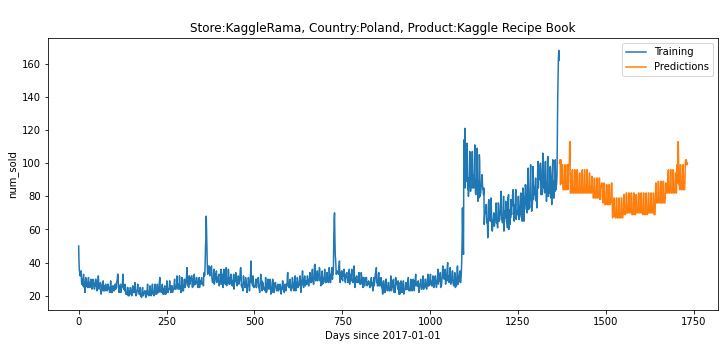

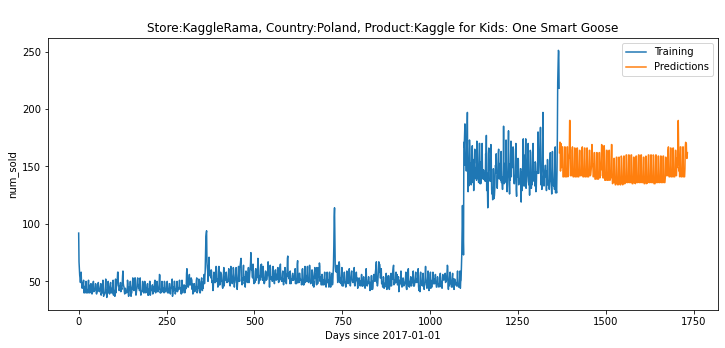

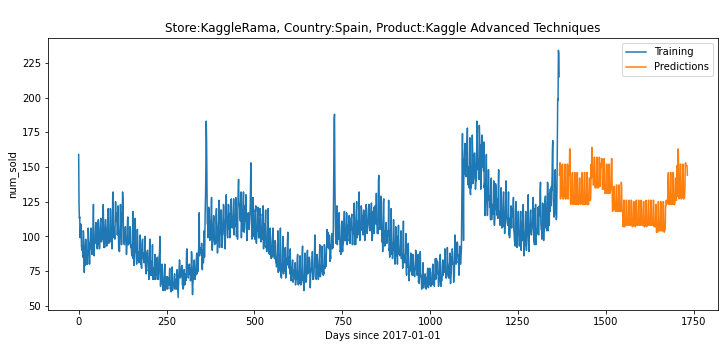

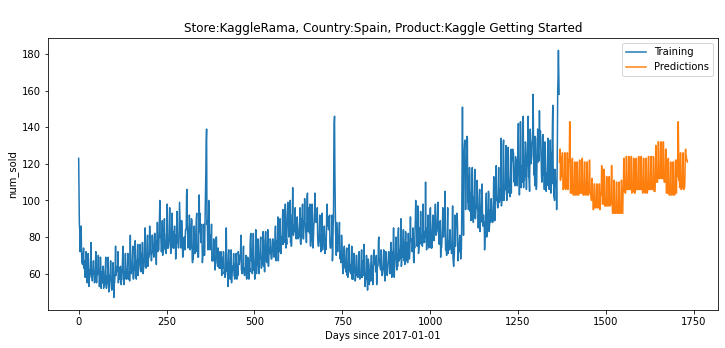

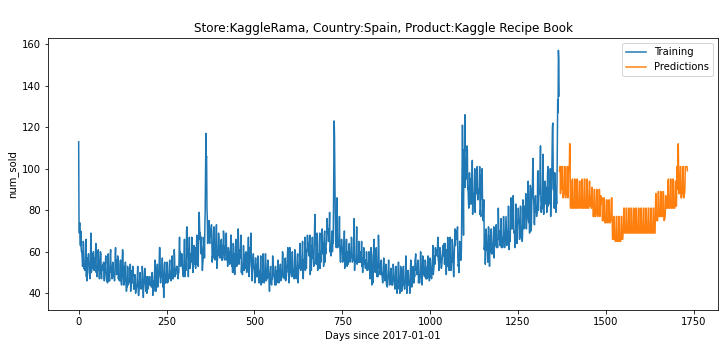

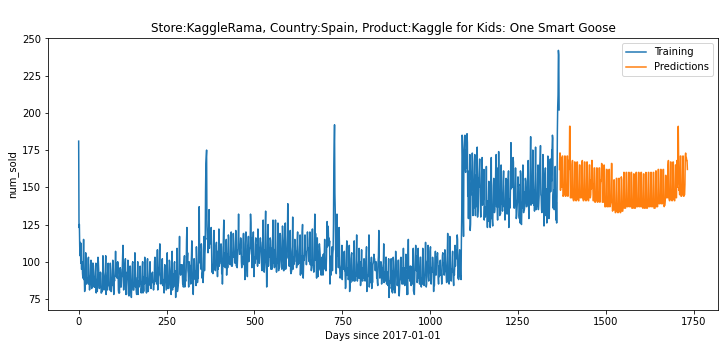

In [874]:
for SS in ['KaggleMart','KaggleRama']:
    for CC in ['Belgium','France','Germany','Italy','Poland','Spain']:
        for PP in ['Kaggle Advanced Techniques','Kaggle Getting Started','Kaggle Recipe Book','Kaggle for Kids: One Smart Goose']:
            plot_predictions(SS, CC, PP)